# BiblioAnalysis_Main

### Version: 0.0.0

### Aims
- This jupyter notebook results from the use analysis of BiblioTools2jupyter notebook and a new implementation of the following parts:
    - Parsing: replaced and tested 
    - Corpus description: replaced and tested
    - Filtering: replaced and tested, integrating the "EXCLUSION" mode and the recursive filtering
    - Cooccurrence analysis : replaced and tested, integrating graph plot and countries GPS coordinates
    - Coupling analyis : replaced and tested
    
### Created modules in the package BiblioAnalysis_Utils
    - BiblioCooc.py
    - BiblioCoupling.py
    - BiblioDescription.py
    - BiblioFilter.py    
    - BiblioGeneralGlobals.py
    - BiblioGlobals.py
    - BiblioGraphPlot.py
    - BiblioGui.py.py
    - BiblioNltk.py
    - BiblioParsingGlobals.py
    - BiblioParsingScopus.py
    - BiblioParsingUtils.py
    - BiblioParsingWos.py
    - BibloRefs.py
    - BiblioTempDev.py

### BiblioTool3.2 source
http://www.sebastian-grauwin.com/bibliomaps/download.html 

### List of initial Python packages extracted from  BiblioTool3.2
- biblio_parser.py	⇒ pre-processes WOS / Scopus data files,
- corpus_description.py	⇒ performs a frequency analysis of the items in corpus,
- filter.py	⇒ filters the corpus according to a range of potential queries but still too specific
- biblio_coupling.py	⇒ performs a BC anaysis of the corpus,
- cooc_graphs.py	⇒ produces various co-occurrence graphs based on the corpus (call parameters changed)

### Specifically required list of pip install 
(to be integrated in the setup.py of BiblioAnalysis_Utils)
- !pip3 install squarify 
- !pip3 install inquirer
- !pip3 install python-louvain
- !pip3 install pyvis

### Specifically required nltk downloads 
(integrated in BiblioNltk.py of BiblioAnalysis_Utils)
- import nltk
    - nltk.download('punkt')
    - nltk.download('averaged_perceptron_tagger')
    - nltk.download('wordnet')

## Preliminary instructions
#### These actions will be interactively performed in the next version of the Jupyter notebook
- Create the 'BiblioAnalysis_Files/' folder in your 'Users/' folder
<br>
<br>
- Create in this 'BiblioAnalysis_Files/' folder, the 'Configuration_Files/' folder
<br>
- Store the configuration files (config_filter.json) a the 'Configuration_Files/' folder that are:
    - 'config_filter.json' used for the filtering of a corpus
    - 'congig_temporal.json'used for the temporal development of item values in a set of annual coupuses 
<br>
<br>
- Create, in the 'Configuration_Files/' folder, your additional_files folder to be named 'Selection_Files/' 
<br>
- Store your files (free names) of selected item values in this additional_files folder together with:
    - 'TempDevK_full.txt' used to select the words to search in the description files of the corpuses for the temporal development of item values in the set of annual coupuses
<br>
<br>
- Create, in the 'BiblioAnalysis_Files/' folder, your project folder
<br>
- Create the 'rawdata/' folder in your project folder
<br>
- Store your corpus file (either wos or scopus extraction) in the 'rawdata/' folder of your project folder
<br>


# I- User environment setting

In [1]:
# Standard library imports
import os
from IPython.display import clear_output
from pathlib import Path

# Local imports
import BiblioAnalysis_Utils as bau

clear_output(wait=True)

# Set the venv use status
venv = False
print('Virtual environment: ', venv)

# Get the information of current operating system
os_name = os.uname().sysname
print('Operating system:    ', os_name)
if os_name=='Darwin':bau.add_site_packages_path(venv)

# User identification
user_root = Path.home()
user_id =  str(user_root)[str(user_root).rfind('/')+1:]
print('User:                ', user_id)
expert =  False

# Select the corpuses folder
corpuses_folder = bau.select_folder_gui(user_root,'Select the corpuses folder')
print('\nCorpuses folder:', corpuses_folder)

Virtual environment:  False
Operating system:     Darwin
Added paths:          /Library/Frameworks/Python.framework/Versions/current/lib/python3.9/site-packages
User:                 amal

Corpuses folder: /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial


# II- Single year corpus analysis

## &emsp;&emsp;II-1 Selection of the corpus file for BiblioAnalysis

In [2]:
# Standard library imports
import os
from pathlib import Path

# Local imports
import BiblioAnalysis_Utils as bau

## Selection of corpus file
corpusfiles_list = os.listdir(corpuses_folder)
corpusfiles_list.sort()
print('Please select the corpus via the tk window')
myprojectname = bau.Select_multi_items(corpusfiles_list,'single')[0]+'/'
project_folder = corpuses_folder /Path(myprojectname)
database_type = input('Corpus file type (scopus, wos - default: "wos")? ')
if database_type =='': database_type = 'wos' 

rep_utils =''
if database_type =='scopus':
     # Get the folder for the general files
     # and specific files for scopus type database in this folder
    if os_name=='Darwin':
        rep_utils = os.path.abspath('BiblioAnalysis_RefFiles')        
    else:
        rep_utils = select_folder_gui(user_root,'Select the folder specific files for scopus')        
    scopus_cat_codes = bau.SCOPUS_CAT_CODES
    scopus_journals_issn_cat = bau.SCOPUS_JOURNALS_ISSN_CAT
    print('Folder of the specific files for scopus:', rep_utils)       
    
## Setting the  graph main heading
digits_list = list(filter(str.isdigit, myprojectname))
corpus_year = ''
for i in range(len(digits_list)):corpus_year = corpus_year + digits_list[i]
init = str(corpuses_folder).rfind("_")+1
corpus_state = str(corpuses_folder)[init:]
main_heading = corpus_year + ' Corpus: ' + corpus_state

## Printing useful information
print('\nSpecific-paths set for user: ', user_id)
print('Project folder:              ', project_folder)
print('Corpus year:                 ', corpus_year)
print('Corpus status:               ', corpus_state)
print('Project name:                ', myprojectname)
print('Corpus file type:            ', database_type)

Please select the corpus via the tk window


Corpus file type (scopus, wos - default: "wos")?  



Specific-paths set for user:  amal
Project folder:               /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small
Corpus year:                  2005
Corpus status:                Initial
Project name:                 Corpus_Iona_2005_small/
Corpus file type:             wos


## &emsp;&emsp;II-2 Data parsing

In [3]:
# Standard libraries import
import os
import json
from pathlib import Path

# Local imports
import BiblioAnalysis_Utils as bau

## Building the names of the useful folders

    # Folder containing the wos or scopus file to process
in_dir_parsing = project_folder / Path(bau.FOLDER_NAMES['rawdata'])

    # Folder containing the output files of the data parsing 
out_dir_parsing = project_folder / Path(bau.FOLDER_NAMES['parsing'])
if not os.path.exists(out_dir_parsing):
    os.mkdir(out_dir_parsing)

## Running function biblio_parser
parser_done = input("Parsing available (y/n)? ")
if parser_done == "n":
     # Setting the specific affiliations filter (default = None)
    inst_filter_dic= {'secondary_inst': ['LITEN', 'INES'],
                      'country': 'France'} 
    #inst_filter_dic = None
    bau.biblio_parser(in_dir_parsing, out_dir_parsing, database_type, expert, rep_utils, inst_filter_dic) 
    with open(Path(out_dir_parsing) / Path('failed.json'), 'r') as failed_json:
            data_failed=failed_json.read()
    dic_failed = json.loads(data_failed)
    articles_number = dic_failed["number of article"]
    print("Parsing processed on full corpus")
    print("\n\nSuccess rates")
    del dic_failed['number of article']
    for item, value in dic_failed.items():
        print(f'    {item}: {value["success (%)"]:.2f}%')
else:
    parser_filt = input("Parsing available without rawdata -from filtering- (y/n)? ")
    if parser_filt == "n":        
        with open(Path(out_dir_parsing) / Path('failed.json'), 'r') as failed_json:
            data_failed=failed_json.read()
        dic_failed = json.loads(data_failed)
        articles_number = dic_failed["number of article"]
        #clear_output(wait=True)
        print("Parsing available from full corpus")
        print("\n\nSuccess rates")
        del dic_failed['number of article']
        for item, value in dic_failed.items():
            print(f'    {item}: {value["success (%)"]:.2f}%')
    else:
        #clear_output(wait=True)
        print("Parsing available from filtered corpus without rawdata")
        file = project_folder /Path('parsing/' + 'articles.dat')
        with open(file) as f:
            lines = f.readlines()
        articles_number = len(lines)

print("\n\nCorpus parsing saved in folder:\n", str(out_dir_parsing))
print('\nNumber of articles in the corpus : ', articles_number)


Parsing available (y/n)?  n


Parsing processed on full corpus


Success rates
    AK: 88.20%
    IK: 72.20%
    TK: 100.00%
    address: 98.60%
    country: 98.40%
    institution: 98.60%
    subject: 100.00%
    subsubject: 100.00%
    authors_inst: 0.40%


Corpus parsing saved in folder:
 /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/parsing

Number of articles in the corpus :  500


###  &emsp;&emsp;II-2.1 Data parsing / Corpus description

Description available (y/n)?  n


Corpus description saved in folder: /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/freq


Treemap for an item of the corpus description (y/n)?  y


Choose the item for treemap in the tk window
Item selected: subjects


Enter the number of items to be used for the treemap (min = 1, max = 72):  20


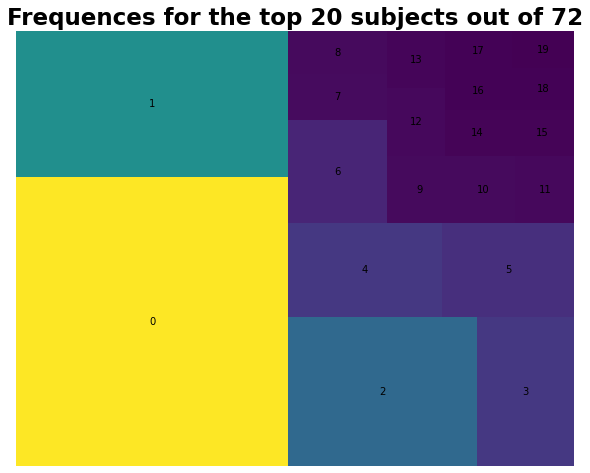

alias subjects                                                    counts  freq
0     Neurosciences & Neurology                                   238     47.6
1     Psychiatry                                                  121     24.2
2     Psychology                                                  85      17.0
3     Behavioral Sciences                                         44      8.8
4     Pharmacology & Pharmacy                                     44      8.8
5     Geriatrics & Gerontology                                    38      7.6
6     Computer Science                                            31      6.2
7     Science & Technology - Other Topics                         14      2.8
8     Zoology                                                     13      2.6
9     Radiology, Nuclear Medicine & Medical Imaging               13      2.6
10    Engineering                                                 13      2.6
11    General & Internal Medicine                           

Scatter plot for the item (y/n)?  y


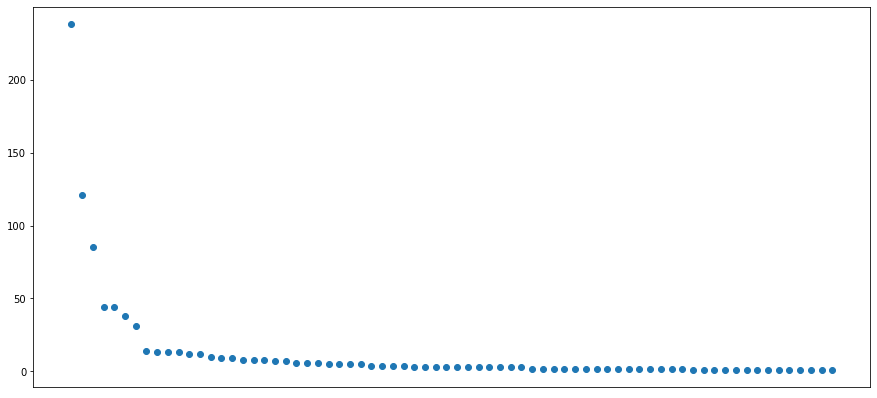

Histogram plot for the item (y/n)?  y


q [[1, 2, 3, 4], [233, 163, 100, 4]]
p [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 31, 38, 44, 85, 121, 238], [72, 58, 43, 32, 28, 24, 21, 19, 16, 14, 13, 11, 8, 7, 6, 5, 3, 2, 1]]


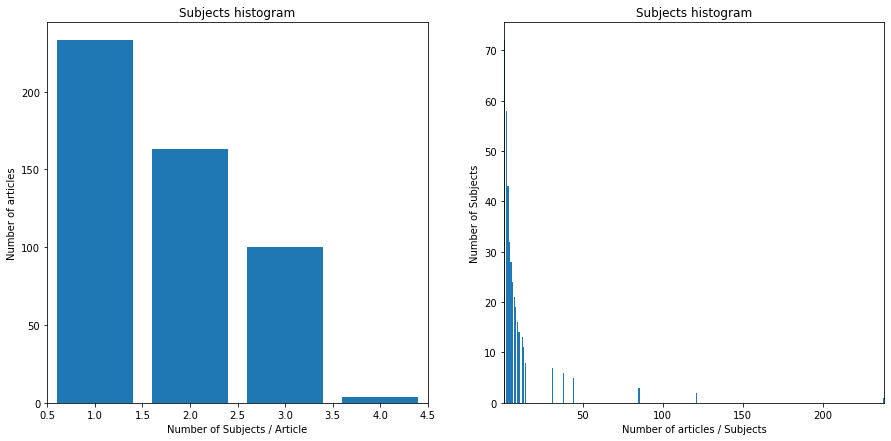



Treemap for a new item (y/n)?  n


In [4]:
# Standard libraries import
import os
import json
from pathlib import Path
from IPython.display import clear_output

# Local imports
import BiblioAnalysis_Utils as bau

## Building the names of the useful folders

    # Folder containing the wos or scopus parsed files
in_dir_corpus = out_dir_parsing

    # Folder containing the wos or scopus parsed and analysed files
out_dir_corpus = project_folder / Path(bau.FOLDER_NAMES['description'])
if not os.path.exists(out_dir_corpus):
    os.mkdir(out_dir_corpus)    

## Running describe_corpus
description_done = input("Description available (y/n)? ")
#clear_output(wait=True)
if description_done == "n":
    verbose = False
    bau.describe_corpus(in_dir_corpus, out_dir_corpus, database_type, verbose)
    print("Corpus description saved in folder:", str(out_dir_corpus))
else:
    print("Corpus description available in folder:", str(out_dir_corpus))

# Building the name of file for histogram plot of an item
fullpath_distrib_item = out_dir_corpus / Path(bau.DISTRIBS_ITEM_FILE)

## Running plot of treemap, scatter plot and histogram for a selected item_treemap
do_treemap = input("Treemap for an item of the corpus description (y/n)? ")
if do_treemap == 'y':
    renew_treemap = 'y'
    while renew_treemap == 'y' :
        print("Choose the item for treemap in the tk window")
        item_treemap = bau.item_selection()
        fullpath_file_treemap = out_dir_corpus / Path('freq_'+ item_treemap +'.dat')
        print("Item selected:",item_treemap)
        bau.treemap_item(item_treemap, fullpath_file_treemap)
        do_scatter = input("Scatter plot for the item (y/n)? ")
        if do_scatter == 'y':
            bau.plot_counts(item_treemap, fullpath_file_treemap)
        do_histo = input("Histogram plot for the item (y/n)? ")
        if do_histo == 'y':
            bau.plot_histo(item_treemap, fullpath_distrib_item)
        renew_treemap = input("\n\nTreemap for a new item (y/n)? ")

# Initialize the variable G_coupl that will receive the biblioanalysis coupling graphs
try: G_coupl
except NameError: G_coupl = None

#### &emsp;&emsp;II-2.1.1 Data parsing / Corpus description / Filtering the data and filtered corpus description
To be run after corpus description to allow using the following functions : describe_corpus() , treemap_item()

Filter configuration folder: /Users/amal/BiblioAnalysis_Files/1_Configuration_Files
Filter configuration file: /Users/amal/BiblioAnalysis_Files/1_Configuration_Files/config_filters.json


Modification of item-values list from a predefined file (y/n)?  n



Saving filter configuration file: /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/filter_1/save_config_filters.json

Filtering status:
   Combine   : union
   Exclusion : True
   Item      : S
   Values    : ['Psychiatry']

Filtered-corpus parsing saved in folder  /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/filter_1  with the corresponding filters configuration
Filtered corpus description saved in folder: /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/freq_1




Draw treemap (y/n)? y




Choose the item for treemap of the filtered corpus description in the tk window
Item selected: subjects


Enter the number of items to be used for the treemap (min = 1, max = 71):  20


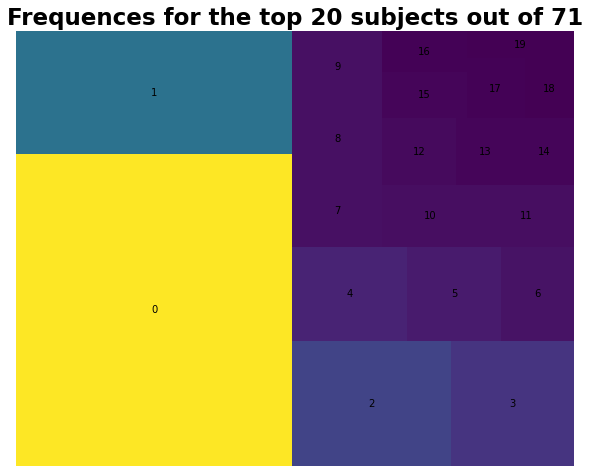

alias subjects                                                    counts  freq
0     Neurosciences & Neurology                                   174     45.91
1     Psychology                                                  69      18.206
2     Behavioral Sciences                                         40      10.554
3     Computer Science                                            31      8.179
4     Geriatrics & Gerontology                                    22      5.805
5     Pharmacology & Pharmacy                                     18      4.749
6     Science & Technology - Other Topics                         14      3.694
7     Zoology                                                     13      3.43
8     Engineering                                                 13      3.43
9     Radiology, Nuclear Medicine & Medical Imaging               13      3.43
10    General & Internal Medicine                                 12      3.166
11    Nutrition & Dietetics               



Treemap for a new item (y/n)?  n
Apply a new filtering process (y/n)?  n


In [5]:
# Standard libraries import
import os
import json
from pathlib import Path
import shutil                      

# Local imports
import BiblioAnalysis_Utils as bau

## Recursive filtering

# Allows prints in filter_corpus_new function
verbose = False

# Initialization of parameters for recursive filtering
filtering_step = 1
while True:

    ## Building the names of the useful folders and creating the output folder if not find 
    if filtering_step == 1:
        in_dir_filter = out_dir_parsing
        ### Get the folder for the filter configuration file 
        filter_config_folder = bau.select_folder_gui(user_root,'Select the folder of config_filters.json file')
        print('Filter configuration folder:', filter_config_folder)
        file_config_filters = filter_config_folder / Path('config_filters.json')
        print('Filter configuration file:',file_config_filters)
        modif_filtering = input("Modification of item-values list from a predefined file (y/n)? ")
        if modif_filtering == "y":
            bau.filters_modification(filter_config_folder,file_config_filters)    
    else:
        renew_filtering = input("Apply a new filtering process (y/n)? ") 
        if renew_filtering == "n": break
        in_dir_filter = project_folder / Path(bau.FOLDER_NAMES['filtering'] + '_' + str(filtering_step-1))
        file_config_filters = in_dir_filter / Path('save_config_filters.json')
        print('Filter configuration file:',file_config_filters) 
        
    out_dir_filter = project_folder / Path(bau.FOLDER_NAMES['filtering'] + '_' + str(filtering_step))
    if not os.path.exists(out_dir_filter): 
        os.mkdir(out_dir_filter)
    else:
        shutil.rmtree(out_dir_filter)

    # Building the absolute file name of filter configuration file to save for the filtering step
    save_config_filters = out_dir_filter / Path(bau.SAVE_CONFIG_FILTERS)
    print('\nSaving filter configuration file:',save_config_filters)
    
    # Configurating the filtering through a dedicated GUI or getting it from the existing file
    bau.filters_selection(file_config_filters,save_config_filters,in_dir_filter) 

    # Read the filtering status
    combine,exclusion,filter_param = bau.read_config_filters(file_config_filters)
    print("\nFiltering status:")
    print("   Combine   :",combine)
    print("   Exclusion :",exclusion)
    for key,value in filter_param.items():
        print(f"   Item      : {key}\n   Values    : {value}\n")

    # Running function filter_corpus_new
    bau.filter_corpus_new(in_dir_filter, out_dir_filter, verbose, file_config_filters)
    file = out_dir_filter /Path('articles.dat')
    with open(file) as f:
        lines = f.readlines()
        articles_number = len(lines)
    if articles_number == 0:
        print('Filtered corpus empty !')
        break
    print("Filtered-corpus parsing saved in folder ", 
            str(out_dir_filter),
            " with the corresponding filters configuration")

        # Folder containing the wos or scopus parsed and filtered files
    in_dir_freq_filt = out_dir_filter

        # Folder containing the wos or scopus parsed, filtered and analysed files
    out_dir_freq_filt = project_folder / Path(bau.FOLDER_NAMES['description'] + '_' + str(filtering_step))
    if not os.path.exists(out_dir_freq_filt): os.mkdir(out_dir_freq_filt)

        # Copying 'database.dat' file in the freq folder for the use in describe_corpus function 
    original = project_folder / Path(bau.FOLDER_NAMES['parsing'] + '/database.dat')
    target = project_folder / Path(bau.FOLDER_NAMES['filtering'] + '_' + str(filtering_step) + '/database.dat')
    shutil.copyfile(original, target)

        # Running describe_corpus 
    verbose = False
    bau.describe_corpus(in_dir_freq_filt, out_dir_freq_filt, database_type, verbose)
    print("Filtered corpus description saved in folder:", str(out_dir_freq_filt))

    # Treemap plot by a corpus item after filtering
    make_treemap = 'n'
    make_treemap = input("\n\nDraw treemap (y/n)?")
    if make_treemap == 'y' :

            # Running plot of treemap for selected item_treemap
        renew_treemap = 'y'    
        while renew_treemap == 'y' :
            print('\n\nChoose the item for treemap of the filtered corpus description in the tk window')
            item_treemap = bau.item_selection()
            file_name_treemap = project_folder / Path(bau.FOLDER_NAMES['description'] + '_'\
                                                      + str(filtering_step) + '/' + 'freq_'+ item_treemap +'.dat')
            print("Item selected:",item_treemap)
            bau.treemap_item(item_treemap, file_name_treemap)
            renew_treemap = input("\n\nTreemap for a new item (y/n)? ") 

    filtering_step=filtering_step + 1



#### &emsp;&emsp;II-2.1.2 Data parsing / Corpus Description / Bibliographic Coupling analysis
To be run after corpus description to use the frequency analysis. You may execute the bibliographic coupling script several times successively on unfiltered corpus and on available filtering steps of the corpus.
The result files are saved in independant folders.

Corpus filtered (y/n)?  y
Enter filtering step :  1


Building the coupling graph of the corpus, please wait...
Building the partition of the corpus, please wait...



Add attributes to the coupling graph nodes (y/n)?  y




Choose the item for the attributes to add in the tk window
Item selected: S  with  3  attributes



Add attributes for a new item (y/n)? n


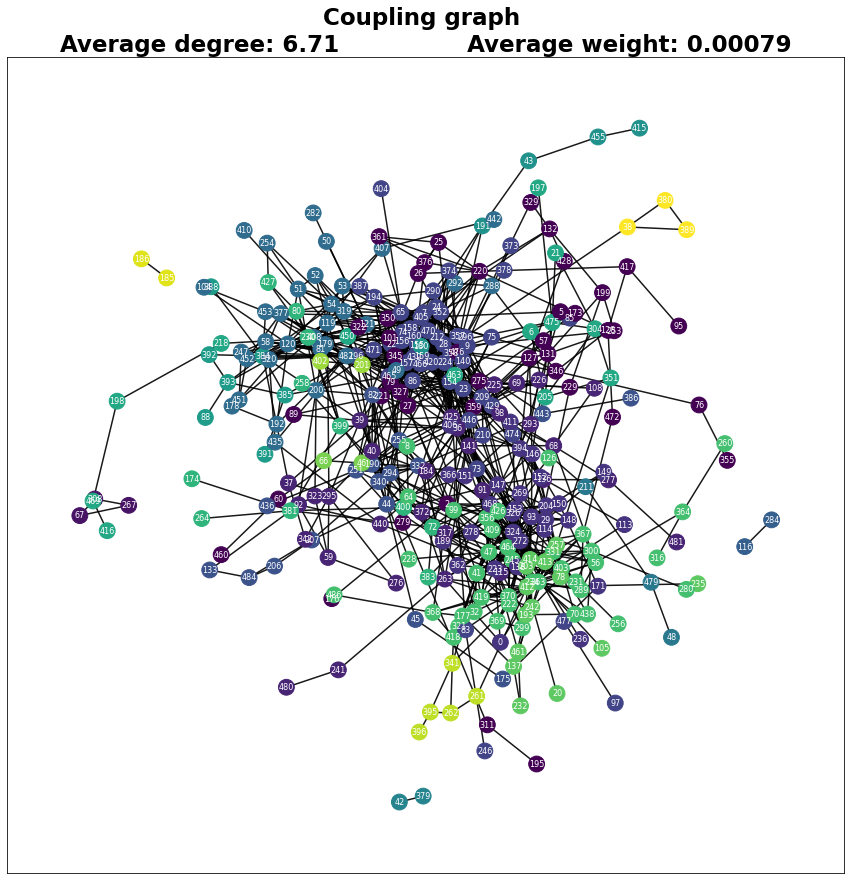


Coupling analysis of the corpus saved as Gephy file in folder:
 /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/coupling_1

Coupling analysis of the corpus saved as EXCEL file in folder:
 /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/coupling_1


In [8]:
# Standard libraries import
import glob
from IPython.display import clear_output

# Local imports
import BiblioAnalysis_Utils as bau

# Building the names of the useful folders and creating the output folder if not find  
filtering = input(
                  "Corpus filtered (y/n)? "
                 )   
if filtering == "y":
    filtering_step = input(
                            "Enter filtering step : "
                          ) 
    in_dir_coupling = project_folder / Path(bau.FOLDER_NAMES['filtering'] + '_' + str(filtering_step))
    in_dir_freq= project_folder / Path(bau.FOLDER_NAMES['description'] + '_' + str(filtering_step))
    out_dir_coupling = project_folder / Path(bau.FOLDER_NAMES['coupling'] + '_' + str(filtering_step))
else:
    in_dir_coupling = out_dir_parsing
    in_dir_freq= out_dir_corpus    
    out_dir_coupling = project_folder / Path(bau.FOLDER_NAMES['coupling'])

if not os.path.exists(out_dir_coupling):
    os.mkdir(out_dir_coupling)
else:
    print('out_dir_coupling exists')
    files = glob.glob(str(out_dir_coupling) + '/*.html')
    for f in files:
        os.remove(f)
    
# Building the coupling graph of the corpus
print('Building the coupling graph of the corpus, please wait...')
G_coupl = bau.build_coupling_graph(in_dir_coupling)

# Building the partition of the corpus
print('Building the partition of the corpus, please wait...')
G_coupl,partition = bau.build_louvain_partition(G_coupl)
print()

# Adding attributes to the coupling graph nodes
attr_dic = {}
add_attrib = input("Add attributes to the coupling graph nodes (y/n)? ")
if add_attrib == 'y':
    while True:
        print('\n\nChoose the item for the attributes to add in the tk window')
        item, m_max_attrs = bau.coupling_attr_selection()
        attr_dic[item] = m_max_attrs
        print("Item selected:",item," with ",m_max_attrs, " attributes" )
        G_coupl = bau.add_item_attribute(G_coupl, item, m_max_attrs, in_dir_freq, in_dir_coupling)
        renew_attrib = input("\nAdd attributes for a new item (y/n)?") 
        if renew_attrib == 'n' : break      

# Plot control of the coupling graph before using Gephy
NODES_NUMBER_MAX = 1
bau.plot_coupling_graph(G_coupl,partition,nodes_number_max=NODES_NUMBER_MAX)

# Creating a Gephy file of the coupling graph  
bau.save_graph_gexf(G_coupl,out_dir_coupling)
print("\nCoupling analysis of the corpus saved as Gephy file in folder:\n", str(out_dir_coupling))

# Creating an EXCEL file of the coupling analysis results
bau.save_communities_xls(partition,in_dir_coupling,out_dir_coupling)
print("\nCoupling analysis of the corpus saved as EXCEL file in folder:\n", str(out_dir_coupling))


#### &emsp;&emsp;II-2.1.3  HTML graph of coupling analysis 
##### after Data parsing / Corpus Description / Coupling analysis  
You may execute the HTML graph construction script several times successively on the available coupling graph of the corpus. The result files are saved in the corresponding coupling floder.

In [9]:
'''Creating html file of graph G using pyviz
   This script uses the results of the Biblioanalysis coupling analysis:
   - out_dir_coupling (Path): path for saving the coupling analysis results;
   - G (networkx object): coupling graph with added attributes;
   - partition (dict):  partition of graph G;
   - attr_dic (dict): dict of added attributes with number of added values. 
   
'''

# Local imports
import BiblioAnalysis_Utils as bau

# Checking the availability of the corpus coupling graph G with all attributes and its partition
assert(G_coupl is not None),'''Please run first the "Bibliographic coupling analysis" 
                                script to build the coupling graph'''

# Setting the item label among the added attribute to be colored
colored_attr = input('Please enter the item label among the added attributes to be colored (default: S)')
if colored_attr == '':colored_attr = 'S'
print('Attribute to be colored:',colored_attr)
if colored_attr == 'S': 
    heading3 = 'Colored by main discipline (grey: without filtering subjects as main discipline).'
else:
    heading3 = 'Colored by main attribute values (grey: without filtering attribute values as main discipline).'
assert(colored_attr in attr_dic.keys()),\
    f'''Selected colored attribute should be among the added attributes: {list(attr_dic.keys())}.
Please run this script again to select an effectivelly added attribute to the coupling graph node 
or run again the "Bibliographic coupling analysis" script to add the targetted attribute to the coupling graph.'''

# Setting the colors for the values of the attribute to be colored
# default: values of 'S' item from a particular corpus
# TO DO: define the list of the attribute values through a GUI
colored_attr_values = {'Neurosciences & Neurology':'0',
                  'Psychology':'1',
                  'Computer Science':'2',
                  'Robotics,Automation & Control Systems':'3',
                  'Life Sciences & Biomedicine - Other Topics':'4',
                  'Biochemistry & Molecular Biology':'4',
                  'Cell Biology':'4',
                  'Evolutionary Biology':'4',
                  'Biomedical Social Sciences':'4',
                  'Biotechnology & Applied Microbiology':'4',
                  'Developmental Biology':'4',
                  'Microbiology':'4',
                  'Marine & Freshwater Biology':'4',
                  'Reproductive Biology':'4',
                  'Genetics & Heredity':'4',
                  'Philosophy':'5',
                  'History & Philosophy of Science':'5',
                  'Social Sciences - Other Topics':'6',
                  'Mathematical Methods In Social Sciences':'6',
                  'Linguistics':'7',
                  'Anthropology':'8',
                 }

# Setting the attribute value to be specifically shaped
shaped_attr = input('Please enter the added attribute value to be specifically shaped (default: Psychology)')
if shaped_attr == '':shaped_attr = 'Psychology'
print('Attribute value to be specifically shaped (triangle):',shaped_attr)
heading4 = 'Triangles for "' + shaped_attr + '" in disciplines.'

# Computing the number of communities
community_number = len(set(partition.values()))
print('Number of communities:',community_number)

# Computing the size of the communities
communities_size = {}
for value in set(partition.values()):
    communities_size[value]=0
    for key in set(partition.keys()):
        if partition[key] == value:
            communities_size[value]+=1
            
# Building the html graphs per community
for community_id in range(community_number):
    community_size = communities_size[community_id] 
    heading2 = 'Coupling graph for community ID: ' + str(community_id) + ' Size: ' + str(community_size)
    heading = '<h1>' + main_heading + '</h1>' + '<h2>' + heading2 + '</h2>' \
                  + '<h3 align=left nowrap>' + heading3 + '<br>'  + heading4 + '</h3>'
    html_file= str(out_dir_coupling /Path('coupling_' + 'com' + str(community_id) \
                                          + '_size' + str(community_size) + '.html'))
    #bau.coupling_graph_html_plot(G_coupl,html_file,community_id,attr_dic,colored_attr,
    #                             colored_attr_values,shaped_attr,nodes_colors,edges_color,
    #                             background_color,font_color,heading)
    bau.coupling_graph_html_nwplt(G_coupl,html_file,community_id,attr_dic,colored_attr,
                                  colored_attr_values,shaped_attr,heading)
# Building the html graph for the full corpus
heading2  = ' All ' + str(community_number) + ' communities'
heading = '<h1>' + main_heading + '</h1>' + '<h2>' + heading2 + '</h2>' \
          + '<h3 align=left nowrap>' + heading3 + '<br>'  + heading4 + '</h3>'
html_file= str(out_dir_coupling /Path('coupling_' + 'all.html'))
#bau.coupling_graph_html_plot(G_coupl,html_file,'all',attr_dic,colored_attr,
#                         colored_attr_values,shaped_attr,nodes_colors,edges_color,
#                         background_color,font_color,heading)
bau.coupling_graph_html_nwplt(G_coupl,html_file,'all',attr_dic,colored_attr,
                              colored_attr_values,shaped_attr,heading)

print("\nCreated html files of graph G_coupl using pyviz for the corpus in folder:\n", str(out_dir_coupling))


Please enter the item label among the added attributes to be colored (default: S) 


Attribute to be colored: S


Please enter the added attribute value to be specifically shaped (default: Psychology) 


Attribute value to be specifically shaped (triangle): Psychology
Number of communities: 21

Created html files of graph G_coupl using pyviz for the corpus in folder:
 /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/coupling_1


### &emsp;&emsp;II-2.2 Data parsing / Co-occurrence Maps
You may execute the co-occurence script several times successively on unfiltered corpus and on available filtering steps of the corpus.
The result files are saved in independant folders.

Corpus filtered (y/n)?  y
Enter filtering step :  1




Choose the item for co-occurrence analysis in the tk window
Item selected: S  at minimum size  10
Co-occurrence analysis of the corpus for item S saved in folder: /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/cooc_1/cooc_S_thr10


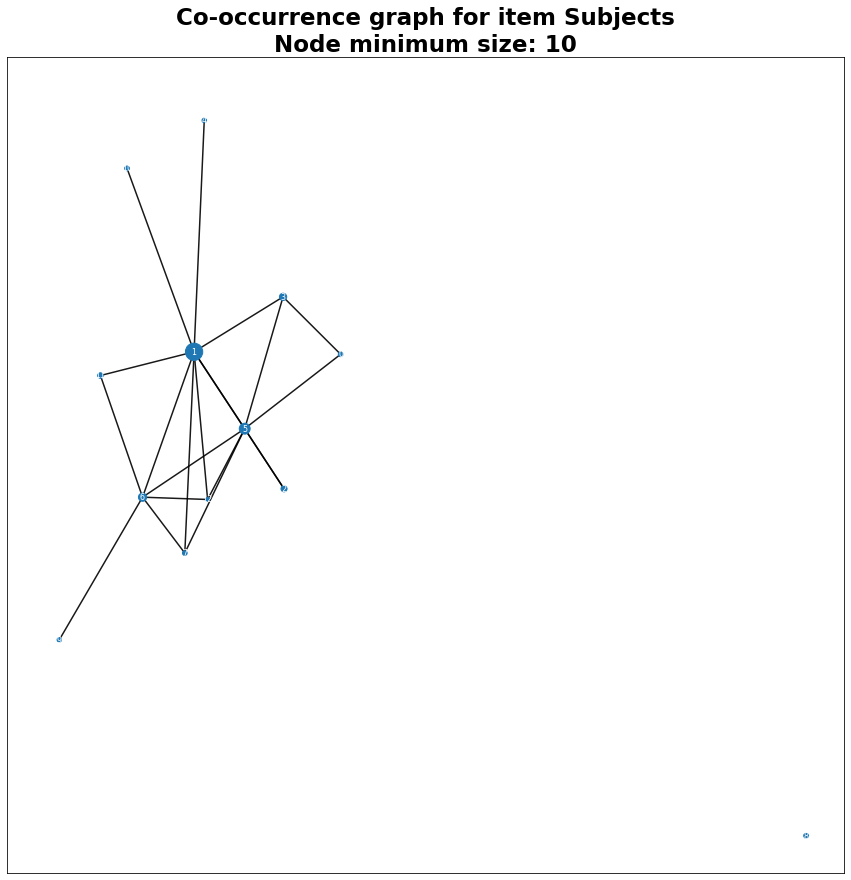

Created html file of S co-occurrence graph using pyviz in folder:
 /Users/amal/BiblioAnalysis_Files/0_Corpuses/1_Initial/Corpus_Iona_2005_small/cooc_1/cooc_S_thr10




Co-occurrence analysis for a new item (y/n)? n


In [11]:
# Local imports
import BiblioAnalysis_Utils as bau

# Building the names of the useful folders and creating the output folder if not find 
filtering = input(
                  "Corpus filtered (y/n)? "
                 )   
if filtering == "y":
    filtering_step = input(
                            "Enter filtering step : "
                          ) 
    in_dir_cooc = project_folder / Path(bau.FOLDER_NAMES['filtering'] + '_' + str(filtering_step))
    out_dir_cooc = project_folder / Path(bau.FOLDER_NAMES['cooccurrence'] + '_' + str(filtering_step))
else:
    in_dir_cooc = out_dir_parsing   
    out_dir_cooc = project_folder / Path(bau.FOLDER_NAMES['cooccurrence']) 

if not os.path.exists(out_dir_cooc):
    os.mkdir(out_dir_cooc)
else:
    print('out_dir_cooc available')

## Building the co-ocurrence graph
size_min = 1
node_size_ref=300
while True :
    print('\n\nChoose the item for co-occurrence analysis in the tk window')
    cooc_item, size_min = bau.cooc_selection() 
    print("Item selected:",cooc_item," at minimum size ",size_min)
    out_dir_cooc_item = out_dir_cooc / Path('cooc_' + cooc_item + \
                                            '_thr' + str(size_min))
    if not os.path.exists(out_dir_cooc_item):
        os.mkdir(out_dir_cooc_item)
    else:
        print('out_dir_cooc_item available')
    G_cooc = bau.build_item_cooc(cooc_item,in_dir_cooc, out_dir_cooc_item, size_min = size_min)
    if G_cooc is None:
        print(f'The minimum node size ({size_min}) is two large. Relax this constraint.')
    else:
        print("Co-occurrence analysis of the corpus for item " + cooc_item + \
          " saved in folder:", str(out_dir_cooc_item))
        heading2 = 'Co_occurence graph for item ' + cooc_item + ' with minimum node size ' + str(size_min)
        heading3 = 'Bold node title: Node attributes[number of item value occurrences-item value (total number of edges)]'
        heading4 = 'Light node titles: Neighbors attributes[number of item value occurrences-item value (number of edges with node)]'
        heading = '<h1>' + main_heading + '</h1>' + '<h2>' + heading2 + '</h2>' \
                  + '<h3 align=left nowrap>' + heading3 + '<br>'  + heading4 + '</h3>'
    
        bau.plot_cooc_graph(G_cooc,cooc_item,size_min=size_min,node_size_ref=node_size_ref)
        # Creating html file of graph G_cooc using pyviz
        html_file= str(out_dir_cooc_item /Path('cooc_' + cooc_item + '_thr' + str(size_min) + '.html'))
        bau.cooc_graph_html_plot(G_cooc,html_file,heading)
        print("Created html file of",cooc_item,"co-occurrence graph using pyviz in folder:\n",\
              str(out_dir_cooc_item))
        
    renew_cooc = input("\n\nCo-occurrence analysis for a new item (y/n)?") 
    if renew_cooc == 'n' : break



# III- Temporal development of item values weight
To run this cell a set of annual corpuses with their description should be available 

In [ ]:
# Standard libraries import
import json
from pathlib import Path
from IPython.display import clear_output

# Local imports
import BiblioAnalysis_Utils as bau

# Initialize the search configuration dict 
keyword_filters = {
    'is_in':[],    
    'is_equal':[]}

## Get the folder for the configuration file for the temporal development analysis 
temporaldev_config_folder = bau.select_folder_gui(user_root,'Select the folder for config_temporal.json file')
print('Item_values selection folder:', temporaldev_config_folder )

## Building the search configuration:
#### - either by reading of the 'config_temporal.json' without modification
#### - or by an interactive modification of the configuration and storing it in this file for a futher use
TemporalDev_file = temporaldev_config_folder / Path('config_temporal.json')

keywords_modif = input('Modification of the keywords list (y/n)?')
if keywords_modif == 'y':
    
        # Selection of items
    items_full_list = ['IK','AK','TK','S','S2']
    print('\nPlease select the items to be analyzed via the tk window')
    items = bau.Select_multi_items(items_full_list,'multiple')

        # Selection of the folder of item-values full-list file
    select_folder = bau.select_folder_gui(user_root,'Select the folder of the item-values list files')

        # Setting the file of the item-values full list  
    keywords_full_list_file = select_folder / Path('TempDevK_full.txt')
    
        # Setting the list of item-values full list
    keywords_full_list = bau.item_values_list(keywords_full_list_file)
    
        # Selection of the item-values list to be put in the temporal development configuration file 
    search_modes = ['is_in','is_equal']
    for search_mode in search_modes:
        print('\nPlease select the keywords for ',search_mode, ' via the tk window')
        keyword_filters[search_mode] = bau.Select_multi_items(keywords_full_list,mode = 'multiple')
        
    # Saving the new configuration in the 'config_temporal.json' file   
    bau.write_config_temporaldev(TemporalDev_file,items,keyword_filters)
    print('\n New temporal development configuration saved in: \n', TemporalDev_file)    
else:
    # Reading the search configuration from the 'config_temporal.json' file  
    items,keywords_param = bau.read_config_temporaldev(TemporalDev_file)
    print('Selection of items:\n',items)    
    keyword_filters['is_in'] = keywords_param['is_in']
    keyword_filters['is_equal'] = keywords_param['is_equal']

## Selection of annual corpus files
corpusfiles_list = os.listdir(corpuses_folder)
corpusfiles_list.sort()
print('\nPlease select the corpuses to be analyzed via the tk window')
years = bau.Select_multi_items(corpusfiles_list,'multiple')

# Print configuration
print('Search items:', items)
print('\nSearch Words:\n' + json.dumps(keyword_filters, indent=2))
print('\n Selection of annual corpus files:\n',years, '\n')

# Performing the search using the keyword_filters dict
keyword_filter_list = bau.temporaldev_itemvalues_freq(keyword_filters ,items, years, corpuses_folder)

# Saving the search results in an EXCEL file
store_file = corpuses_folder / Path('Results_Files/TempDev_synthesis.xlsx')
bau.temporaldev_result_toxlsx(keyword_filter_list,store_file)
print('\nTemporal development results saved in:\n', store_file) 


# Annexe 1- Databases merging

In [ ]:
# Local imports
import BiblioAnalysis_Utils as bau

database, filename, in_dir, out_dir = bau.merge_database_gui()
bau.merge_database(database,filename,in_dir,out_dir)

# Annexe 2- Item values selection to list for filters configuration

In [ ]:
# Standard library imports
from pathlib import Path

# Local imports
import BiblioAnalysis_Utils as bau

# Get the folder for the filter configuration file 
filter_config_folder = bau.select_folder_gui(user_root,'Select the folder for the config_filters.json file')
print('Filter configuration folder:', filter_config_folder) 

file_config_filters = filter_config_folder/ Path('config_filters.json')    
bau.filters_modification(filter_config_folder,file_config_filters)

# Documentation

## Data parsing
- articles.dat is the central file, listing all the publications within the corpus. It contains informations such as the document type (article, letter, review, conf proceeding, etc), title, year of publication, publication source, doi, number of citations (given by WOS or Scopus at the time of the extraction) AND a unique identifier used in all the other files to identify a precise publication.
- database.dat keeps track of the origin of the data, some part of the analysis being specific to WOS or Scopus data.
- authors.dat lists all authors names associated to all publications ID.
- addresses.dat lists all adresses associated to all publications ID, along with a specific ID for each adresse line. These adresses are reported as they appear in the raw data, without any further processing.
- countries.dat lists all countries associated to all publications ID and adresses lines ID. The countries are extracted from the adresses fields of the raw data, with some cleaning (changing mentions of US states and UK countries to respectively the USA and UK).
- institutions.dat lists all the comma-separated entities appearing in the adresses field associated to all publications ID and adresses lines ID, except those refering to a physical adresses. These entities correspond to various name variants of universities, organisms, hospitals, labs, services, departments, etc as they appear in the raw data. No treatment is made to e.g. filtering out the entities corresponding a given hierarchy level.
- keywords.dat lists various types of keywords associated to all publications ID. "AK" keywords correspond to Author's keywords. "IK" keywords correspond to either WOS or Scopus keywords, which are built based on the authors' keywords, the title and abstract. "TK" correspond to title words (from which we simply remove common words and stop words - no stemming is performed). TK are especially useful when studying pre-90's publications, when the use of keywords was not yet standard.
- references.dat lists all the references associated to all publications ID. The rawdata is parsed to store the first author name, title, source, volume and page of each reference of the raw "references" field.
- subjects.dat lists all subject categories associated to all publications ID (a journal may be associated to many subject category). WOS classifies the sources it indexes into ∼ 250 categories, that are reported in the extracted data. Scopus classifies its sources into 27 major categories and ∼ 300 sub-categories, none of which are reported in the extracted data. We use Elsevier Source Title List (october 2017 version) to retrieve that information. The "subject.dat" contains the info relative to the major categories.
- subjects2.dat lists Scopus's sub-categories, if the use database is Scopus.
- AA_log.txt keeps track of the date/time the script was executed and of all the messages displayed on the terminal (number of publications extracted, % of references rejected, etc).

##  Corpus description
Before doing anything else, you should get a general idea of the content of your database.  This script performs several basic tasks:
- it performs a series of frequency analysis, computing the number of occurrences of each item (authors, keywords, references, etc) within the publications of the corpus. These frequencies are automatically stored into several "freq_xxx.dat" files within a newly created "freq" folder.
- it performs a series of generic statistical analysis, storing the numbers of distinct items of each type (e.g. there are x distinct keyword in the corpus ), the distributions of number of occurrences of each item (e.g. there are x keywords appearing in at least y publications) and the distribution of number of items per publication (e.g.there are x% of publications with y keywords). All these statistics are stored in the "DISTRIBS_itemuse.json" file.
- it also performs a co-occurrence analysis, computing the number of co-occurrence of pairs of items among the top 100 most frequent items of each type (e.g. computing how often the two most used keywords appear together in the same publications). The results of this analysis are stored in the "coocnetworks.json" file. More systematic co-occurrence analysis can also be performed with another script, cf the Co-occurrence Maps section below.
All the generated files can be opened and read with a simple text editor. The freq_xxx.dat, listing items by order of frequency, can also be read in a spreadsheet software such as excel. All the files are however primarily made to be read in the BiblioMaps interface.

## Filtering the data
#### To be run after corpus description to allow using the following functions : describe_corpus() , treemap_item()

If, upon exploring the nature of the data you realize that before going further you'd prefer to filter your corpus based on some characteristic (keeping only the publications from certain years, using some keywords or references, written by some authors from some countries, etc), you can filter the initial corpus thanks to the script:

- python BiblioTools3.2/filter.py -i myprojectname/ -o myprojectname_filtered -v <br>

Edit the 'filter.py' file to specify your filters. You'll also need to create a new "myprojectname_filtered" main folder before running the script.
- create the files articles.dat, addresses.dat, authors.dat, countries.dat, institutions.dat, keywords.dat, references.dat, subjects.dat, subjects2.dat

### Co-occurrence Maps
You may execute the co-occurrence script several times successively on unfiltered corpus and on available filtering steps of the corpus.
The result files are saved in independant folders.

The script create multiple co-occurrence networks, all stored in gdf and gexf files that can be opened in Gephi, among which:

Example of heterogeneous network generated with BiblioAnlysis and visualized in Gephi.

- a co-cocitation network, linking references that are cited in the same publications.
- a co-refsources network, linking references's sources that are cited in the same publications.
- a co-author network, linking authors that collaborated in some publications.
- a co-country network, linking countries with researchers that collaborated in some publications.
- a co-institution network, linking institutions with researchers that collaborated in some publications. For this network to be fully useful, you may want to spend some time cleaning the "institutions.dat", e.g. by keeping only the big institutions (university level) or by replacing minor name variant by the dominant name variant ("Ecole Normale Supérieure de Lyon" → "ENS Lyon")
- a co-keyword network, linking keywords being co-used in some publications. Be careful about the interpretation: keywords can be polysemic, their meaning differing from field to another (eg "model", "energy", "evolution", etc).

# Test of GUI
on going work

In [12]:
def get_displays(): 
    
    '''
    '''
    # Standard library imports
    import math
    
    # 3rd party imports
    from screeninfo import get_monitors
    
    displays = [{'x':m.x,'y':m.y,'width':m.width,
                 'height':m.height,'width_mm':m.width_mm,
                 'height_mm':m.height_mm,'name':m.name,
                 'is_primary':m.is_primary} for m in get_monitors()]
    
    for disp in range(len(displays)):
        width_px = displays[disp]['width']
        height_px = displays[disp]['height']
        diag_px = math.sqrt(int(width_px)**2 + int(height_px)**2)    
        width_mm = displays[disp]['width_mm']
        height_mm = displays[disp]['height_mm']
        if width_mm is None or height_mm is None:        
            diag_in = float(input('Enter the diagonal size of the screen in inches'))
            width_mm = round(int(width_px) * (diag_in/diag_px) * IN_TO_MM,1)
            height_mm = round(int(height_px) * (diag_in/diag_px) * IN_TO_MM,1)
            displays[disp]['width_mm'] = str(width_mm)
            displays[disp]['height_mm'] = str(height_mm)
        else:
            diag_in = math.sqrt(float(width_mm) ** 2 + float(height_mm) ** 2) / IN_TO_MM
        displays[disp]['ppi'] = round(diag_px/diag_in,2)
        
    return displays

In [ ]:
# Set the globals for select_folder_gui function
IN_TO_MM = 25.4
DISPLAYS = get_displays()
PRIME_DISP = [i for i in range(len(DISPLAYS)) if DISPLAYS[i]['is_primary']][0]
print(DISPLAYS)

In [ ]:
def select_folder_gui_place(in_dir, titles, buttons_labels, prime_disp=0, widget_ratio=1.2):
    
    '''The function `select_folder_gui_grid` allows the interactive selection of a folder.
    
    Args: 
        in_dir (str): name of the initial folder.
        titles (dict): title of the tk window. 
    
    Returns:
        `(str)`: name of the selected folder.
        
    Note:
        Uses the globals: `IN_TO_MM`;`DISPLAYS`.
        Based on two frames in the main window and two buttons in the top frame.

    '''
    # Standard library imports 
    import math
    import re
    import tkinter as tk
    from tkinter import messagebox
    from tkinter import filedialog
    import tkinter.font as TkFont
    
    global out_dir
 
    ############# Definition of local functions #############
    
      ## Define the mm to pixels conversion lambda function
    mm_to_px = lambda size_mm,fact : math. ceil((size_mm * fact / IN_TO_MM) * ppi)
    
      ## Define lambda function that get the maximum length of the titles in mm
    str_max_len_mm = lambda list_strs,font,ppi :max([str_size_mm(value, font, ppi)[0] 
                                           for value in list_strs])
    
    def str_size_mm(text, font, ppi):
        '''The function `str_size_mm` computes the sizes in mm of a string.
        
        Args:
            text (str): the text of which we compute the size in mm.
            font (tk.font): the font of the text.
            ppi (int): pixels per inch of the display.
        
        Returns:
            `(tuple)`: width in mm `(string)`, height in mm `(string)`.
            
        Note:
            The use of this function requires a tkinter window availability 
            since it is based on a tkinter font definition.
            
        '''

        (w_px,h_px) = (font.measure(text),font.metrics("linespace"))
        w_mm = w_px * IN_TO_MM / ppi
        h_mm = h_px * IN_TO_MM / ppi

        return (w_mm,h_mm )
    
    def split_path2str(in_dir,max_px,font,ppi):
        '''The function `split_path2str` splits the `in_dir` string 
        in substrings of pixels sizes lower than `max_px`.
        
        Args:
            in_dir (str): the full path of a folder.
            max_px (int): the maximum size in pixels for the substrings 
                          that should result from the split of `in-dir`.
            font (tk.font): the font used for the substrings size evaluation in mm.
            ppi (int): pixels per inch of the display.
        
        Returns:
            `(tuple)`: tuple of the substrings resulting from the split of `in-dir`.
            
        Note:
            The use of this function requires a tkinter window availability 
            since it is based on a tkinter font definition.
            
        '''        
          
        # Standard library imports 
        import numpy as np
        import re

        len_in_dir,_ = str_size_mm(in_dir, font, ppi)
        if mm_to_px(len_in_dir,1)>int(max_px):
            pos_list = np.array([m.start() for m in re.finditer(r"[\\/]", in_dir)])
            list_len = [mm_to_px(str_size_mm(in_dir[0:pos_slash], font, ppi)[0],1)
                        for pos_slash in pos_list ]
            try:
                pos_mid = pos_list[np.min(np.where(np.array(list_len) >= int(max_px))) - 1]
            except:
                pos_mid = pos_list[-1]
            out_dir1 = str(in_dir)[0:pos_mid]
            out_dir2 = str(in_dir)[pos_mid:]

        else:
            out_dir1 = str(in_dir)
            out_dir2 = ''

        return (out_dir1,out_dir2)

    def outdir_folder_choice():
        '''The function `outdir_folder_choice' allows the interactive choice of a folder, 
        puts it in the `out_dir` global variable and prints the result in the `folder_choice` frame.

        '''
        # Standard library imports
        import numpy as np

        global out_dir

        out_dir = filedialog.askdirectory(initialdir=in_dir,title=titles['main'])
        
        out_dir_split = [out_dir]
        while out_dir_split[len(out_dir_split)-1]!='':
            out_dir1,out_dir2 = split_path2str(out_dir_split[len(out_dir_split)-1],frame_widthpx,text_font,ppi)
            out_dir_split[len(out_dir_split)-1] = out_dir1
            out_dir_split.append(out_dir2)

         # Create the folder-result frame and set its geometry 
        folder_result = tk.LabelFrame(master=win,              
                        text=titles['result'],
                        font=frame_font)
        folder_result.place(x=frame_xpx,
                            y=frame_ypx,
                            width=frame_widthpx,
                            height=frame_heightpx)

         # Edit the selected folder        
        text_max_widthmm = str_max_len_mm(out_dir_split, text_font, ppi)
        text_xmm = (frame_widthmm - text_max_widthmm) / 2
        text_xpx = mm_to_px(text_xmm - mm_size_corr,1)
        text_ypx = mm_to_px(pad_ymm,1)       
        text = '\n'.join(out_dir_split)
        folder_label = tk.Label(folder_result, text=text, font=text_font)
        folder_label.place(x=text_xpx,
                           y=text_ypx)
    
    def help():
        messagebox.showinfo('Folder selection info', '')
    
    ############# Local parameters setting #############  
    
     # Get the ppi of the selected prime display
    ppi = DISPLAYS[prime_disp]['ppi']
    
     # Check the number of frames and buttons
    frames_nb = len(titles) -1 
    buttons_nb = len(buttons_labels)
    if frames_nb!=1 or buttons_nb!=2:
        print('Number of titles:', len(titles) )
        print('Number of buttons:', len(button_labels) )
        print('The number of titles should be 2 and the number of buttons should be 2')
    
     # Set the frames-width to the titles-max-width ratio
    frame_ratio = widget_ratio
    
     # Set the window-width to the frame-width ratio
    win_ratio = widget_ratio 
    
     # Set the buttons-height to the label-height ratio to vertically center the label in the button
    button_ratio = 2.5
    
     # Set a potential ratio for correcting the conversion of mm to px for the buttons sizes
     # Todo: adapt these ratios to correct the discrepancy between the set mm sizes 
     # and the effective mm sizes on the screen for MacOs 
     # (correction still to be understood)
    buttonsize_mmtopx_ratios = (1,1,1)
    
     # Set the value in mm for the correction of the sizes in milimeters 
     # before use for computing the horizontal positions in pixels 
     # (correction still to be understood)
    mm_size_corr = 1
    
     # Set the lines maximum number for editing the selected folder name
    max_lines_nb = 3 
    
    
    max_frame_unit_nb = 4 + max_lines_nb  # 2 frame units above and 2 frame units under the edited text
    
    ############# Tkinter window management #############
    
     # Create the tk window
    win = tk.Tk()
    win.attributes("-topmost", True)
    win.title(titles['main']) 
    
     # Set the fonts to be used
    frame_font = TkFont.Font(family='arial', size=16, weight='bold')
    text_font = TkFont.Font(family='arial', size=12, weight='normal')
    button_font = TkFont.Font(family='arial', size=12, weight='normal')
    
     # Computes the maximum size in mm of the list of titles
    titles_mm_max = str_max_len_mm(titles.values(), frame_font, ppi)
    
     # Computes button sizes in mm and pixels using button label sizes and button_ratio
     # Buttons width is the button heigth added to the labels width to horizontally center the label in the button 
    labels_widthmm = [str_size_mm(buttons_labels[i],button_font, ppi)[0] for i in range(buttons_nb)]
    label_heightmm = str_size_mm(buttons_labels[0],button_font, ppi)[1]
    button_heightmm =  label_heightmm * button_ratio
    buttons_widthmm = (labels_widthmm[0] + button_heightmm, labels_widthmm[1] + button_heightmm)
    buttons_widthpx = (mm_to_px(buttons_widthmm[0],buttonsize_mmtopx_ratios[0]), 
                       mm_to_px(buttons_widthmm[1],buttonsize_mmtopx_ratios[1]))
    button_heigthpx = mm_to_px(button_heightmm,buttonsize_mmtopx_ratios[2])

     # Computes the frame width in pixels from titles maximum size in mm using frame_ratio
    frame_widthmm = titles_mm_max * frame_ratio    
    frame_widthpx = str(mm_to_px(frame_widthmm,1))

     # Computes the window width in pixels from the frame width and buttons width using win_ratio
    win_widthmm = max(frame_widthmm,sum(buttons_widthmm)) * win_ratio 
    win_widthpx = str(mm_to_px(win_widthmm,1))

     # Computes the buttons horizontal positions in pixels 
     # assuming 2 buttons and with correction of size in mm by mm_size_corr value
    padx_ratio = buttons_nb * 2 # 
    pad_xmm = (win_widthmm - min(frame_widthmm,sum(buttons_widthmm))) / padx_ratio
    buttons_xmm = (pad_xmm, buttons_widthmm[0] + 3 * pad_xmm)
    buttons_xpx = (mm_to_px(buttons_xmm[0] - mm_size_corr,1), mm_to_px(buttons_xmm[1] - mm_size_corr,1))

     # Computes the frames heigth unit
    text_font = TkFont.Font(family='arial', size=12, weight='normal')
    _, text_heigthmm = str_size_mm('Users/',text_font, ppi)
    frame_unit_heightmm = min(button_heightmm,text_heigthmm) 
    print('frame_unit_heightmm:',frame_unit_heightmm)

     # Computes the buttons vertical position in pixels
    button_ymm = frame_unit_heightmm 
    print('buttons y pos:',button_ymm)
    button_ypx = mm_to_px(button_ymm,1)

     # Computes the frame heigth in pixels
    max_frame_unit_nb = 4 + max_lines_nb  # 2 frame units above and 2 frame units under the edited text
    pads_nb = max_frame_unit_nb - max_lines_nb # 2 pads above and 2 pads under the edited text    
    frame_unit_nb =  max_lines_nb + pads_nb
    
    #pad_ymm = frame_unit_heightmm
    frame_heightmm = frame_unit_heightmm * max_frame_unit_nb          # max_lines_nb + pad_ymm * pads_nb
    print('frame_heightmm:', frame_heightmm)
    frame_heightpx = str(mm_to_px(frame_heightmm,1))

     # Computes the frame positions in pixels
    frame_xmm = (win_widthmm - frame_widthmm) / 2
    frame_ymm = button_ymm + button_heightmm + 2 * frame_unit_heightmm
    print('frames x pos:',frame_xmm)
    print('frames y pos:',frame_ymm)
    frame_xpx, frame_ypx = mm_to_px(frame_xmm,1), mm_to_px(frame_ymm,1)

     # Computes the window heigth in pixels
    win_heightmm = button_ymm + button_heightmm + frame_heightmm + 3 * frame_unit_heightmm
    print('win_heightmm:',win_heightmm)
    win_heightpx = str(mm_to_px(win_heightmm,1))

     # Set the window geometry
    win_xpx = str(int(DISPLAYS[prime_disp]['x']) + 50)
    win_ypx = str(int(DISPLAYS[prime_disp]['y']) + 50)
    win.geometry(f'{win_widthpx}x{win_heightpx}+{win_xpx}+{win_ypx}')
    #win.resizable(0, 0)

     # Create the folder result frame and set its geometry 
    folder_result = tk.LabelFrame(master=win,              
                text=titles['result'],
                font=frame_font)
    folder_result.place(x=frame_xpx,
                    y=frame_ypx,
                    width=frame_widthpx,
                    height=frame_heightpx)

     # Create the button for folder selection
    select_button = tk.Button(win,
                          text=buttons_labels[0],
                          font=button_font,
                          command=outdir_folder_choice)
    select_button.place(x=buttons_xpx[0], 
                    y=button_ypx, 
                    width=buttons_widthpx[0], 
                    height=button_heigthpx)

     # Create the help button
    help_button = tk.Button(win,
                        text=buttons_labels[1],
                        font=button_font,
                        command=help)
    help_button.place(x=buttons_xpx[1], 
                  y=button_ypx, 
                  width=buttons_widthpx[1], 
                  height=button_heigthpx)

    win.mainloop()

In [ ]:
# Standard library imports
from pathlib import Path

user_root = Path.home()

 # Set the widget ratio to set the window size
gui_widget_ratio = 1.2

 # Get the prime display choice
input_disp = input('Select Id of gui prime-display '+
                   '(value: 0 to '+ str(len(DISPLAYS)-1)+
                  '; default:'+ str(PRIME_DISP)+')')
if input_disp:
    gui_prime_disp = int(input_disp)
else:
    gui_prime_disp = PRIME_DISP

 # Get the corpuses folder
gui_titles = {'main':   'Folder selection window',
              'result': 'Selected folder'}
gui_buttons = ['SELECTION','HELP']

corpuses_folder = select_folder_gui_place(user_root, gui_titles, gui_buttons, gui_prime_disp, gui_widget_ratio)
print('Corpuses folder:', corpuses_folder)
